In [18]:

import brainscore_vision
import torch
import numpy as np

# Imports
import numpy as np
from matplotlib import image
from matplotlib import pyplot as plt
from recognition_parametrised_model import RPM

from matplotlib import pyplot as plt
from save_load import rpm_save, rpm_load

import torch
import torch.nn.functional as F



neural_data = brainscore_vision.load_dataset("MajajHong2015.public")
#neural_data = neural_data.transpose('presentation', 'neuroid', 'time_bin')
#neural_data



# Compact data
compact_data = neural_data.multi_groupby(['category_name', 'object_name', 'stimulus_id', 'variation']).mean(dim='presentation')  # (1)
compact_data = compact_data.sel(region='IT')  # (2)
compact_data = compact_data.squeeze('time_bin')  # (3)
compact_data = compact_data.transpose('presentation', 'neuroid')  # (4)

# All Images
stimulus_set = neural_data.attrs['stimulus_set']

# Neural Recordings
neural_observation = compact_data.data

# Stimulus labels
label_basic, basic_index = np.unique(compact_data['category_name'].data, return_inverse=True)
label_categories, categories_index = np.unique(compact_data['object_name'].data, return_inverse=True)

# Level of difficulty/variation for each images
variation = compact_data['variation'].data

# Find trials with given level of difficulty
#select_variation = np.where(variation >= 0)[0]
select_variation = np.where(variation == 3)[0]
#select_variation = np.where(variation == 0)[0]

# Filter the dataset Using the trials with given level of difficulty
filtered_neural = np.array(neural_observation[select_variation])
filtered_latent_basic = basic_index[select_variation]
filtered_latent_categories = categories_index[select_variation]

#%%

# Combined Train and Test set sizes
num_observations_tot = len(filtered_neural)
assert num_observations_tot == len(filtered_latent_basic)
assert num_observations_tot == len(filtered_latent_categories)

# Gather images
images_height = 256
images_width = 256

# Gather Images
filtered_images = torch.zeros(num_observations_tot, images_height, images_width)
for ii in range(num_observations_tot):
    path_cur = compact_data['stimulus_id'].data[select_variation][ii]
    path_cur = stimulus_set.get_stimulus(path_cur)
    ima_cur = image.imread(path_cur)[:, :, 0]
    filtered_images[ii] = torch.tensor(ima_cur)

# Downsample images
ds_factor = 0.4
filtered_images = torch.nn.functional.interpolate(filtered_images.unsqueeze(dim=1), scale_factor=ds_factor, mode='bilinear')
filtered_images = filtered_images.squeeze(dim=1)

#%%

filtered_images = filtered_images[:, 25:75][:, :, 25:75]
#%%


In [19]:
filtered_images.shape 

torch.Size([2560, 50, 50])

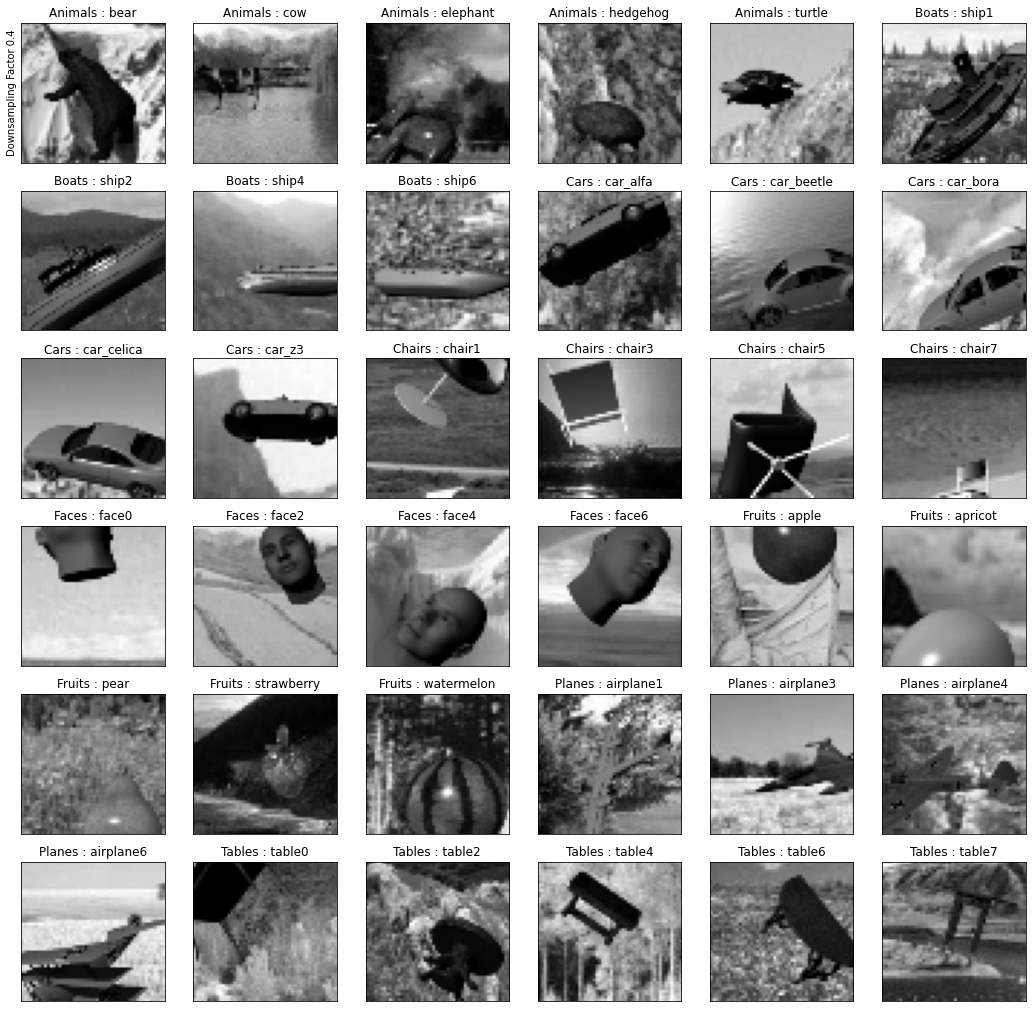

In [20]:

#%% Plot
do_plot = True
if do_plot:
    num_plot = 35
    plot_check = np.arange(0, num_observations_tot, int(num_observations_tot / num_plot))

    figh = int(np.ceil(np.sqrt(len(plot_check))))
    figw = int(np.ceil(np.sqrt(len(plot_check))))

    plt.figure(figsize=(3 * figw, 3 * figh))
    for ii, id in enumerate(plot_check):
        plt.subplot(figh, figw, ii + 1)
        lab_basic = label_basic[filtered_latent_basic[id]]
        lab_categories = label_categories[filtered_latent_categories[id]]

        plt.imshow(filtered_images[id], cmap='gray', aspect='auto')
        plt.title(lab_basic + ' : ' + lab_categories)
        plt.xticks([])
        plt.yticks([])

        if ii == 0:
            plt.ylabel('Downsampling Factor ' + str(ds_factor))



In [21]:
#%%

#%% Builds

# Build Observations
observations1 = filtered_images
observations2 = torch.tensor(filtered_neural)

# Random train /test split
train_test_perm = torch.randperm(num_observations_tot)
train_length = int(num_observations_tot/2)
train_indices = train_test_perm[:train_length]
tests_indices = train_test_perm[train_length:]

observations1_train = observations1[train_indices]
observations2_train = observations2[train_indices]
observations1_tests = observations1[tests_indices]
observations2_tests = observations2[tests_indices]

true_latent_train = filtered_latent_basic[train_indices]
true_latent_tests = filtered_latent_basic[tests_indices]

# GPUs ?
dtype = torch.float32
torch.set_default_dtype(dtype)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


# Gather and move obs
observations_train = (observations1_train.to(device).unsqueeze(1), observations2_train.to(device).unsqueeze(1))
observations_tests = (observations1_tests.to(device).unsqueeze(1), observations2_tests.to(device).unsqueeze(1))


#%%


cuda


In [22]:
observations_train[0].shape 


torch.Size([1280, 1, 50, 50])

In [23]:
# Shuffle pairs and use multi/uni-modal input
do_shuffle = True

if do_shuffle:
    
    # Select What Type of factors to use [0: images, 1: neural]
    factors = [0, 1]
    
    # Number of pairs
    num_observations_shuffled = 1000

    # All indices of the current dataset
    all_classes = np.unique(true_latent_train)
    num_classes = len(all_classes)
    
    # Random list of true latent indices
    shuffled_classes = all_classes[torch.round((num_classes-1) * torch.rand(num_observations_shuffled)).numpy().astype(int)]
    
    # Init Training Observations
    observations_shuffled = [torch.zeros(num_observations_shuffled, *observations_train[ii].shape[1:]) for ii in factors]
    
    # Randomly assign each observation
    for ii in range(num_observations_shuffled):
        
        # Sample observations
        mask = np.where(shuffled_classes[ii] == true_latent_train)[0]
        observation_indices = torch.randperm(len(mask))[:len(factors)]
        
        # Assign it to each factors
        for jj in range(len(factors)):
            observations_shuffled[jj][ii] = observations_train[factors[jj]][mask[observation_indices[jj]]]

    # Move and Copy (if necessary, for the test set) observaions
    observations_train = [ii.to(device) for ii in observations_shuffled]
    observations_tests = [observations_tests[ii].to(device) for ii in factors]
    
    true_latent_train = torch.tensor(shuffled_classes)
    true_latent_tests = torch.tensor(true_latent_tests)


observations_train = [ii for ii in observations_train]
observations_tests = [ii for ii in observations_tests]



In [24]:
print(observations_train[0].shape)

torch.Size([1000, 1, 50, 50])


Text(0.5, 0, 'Epoch')

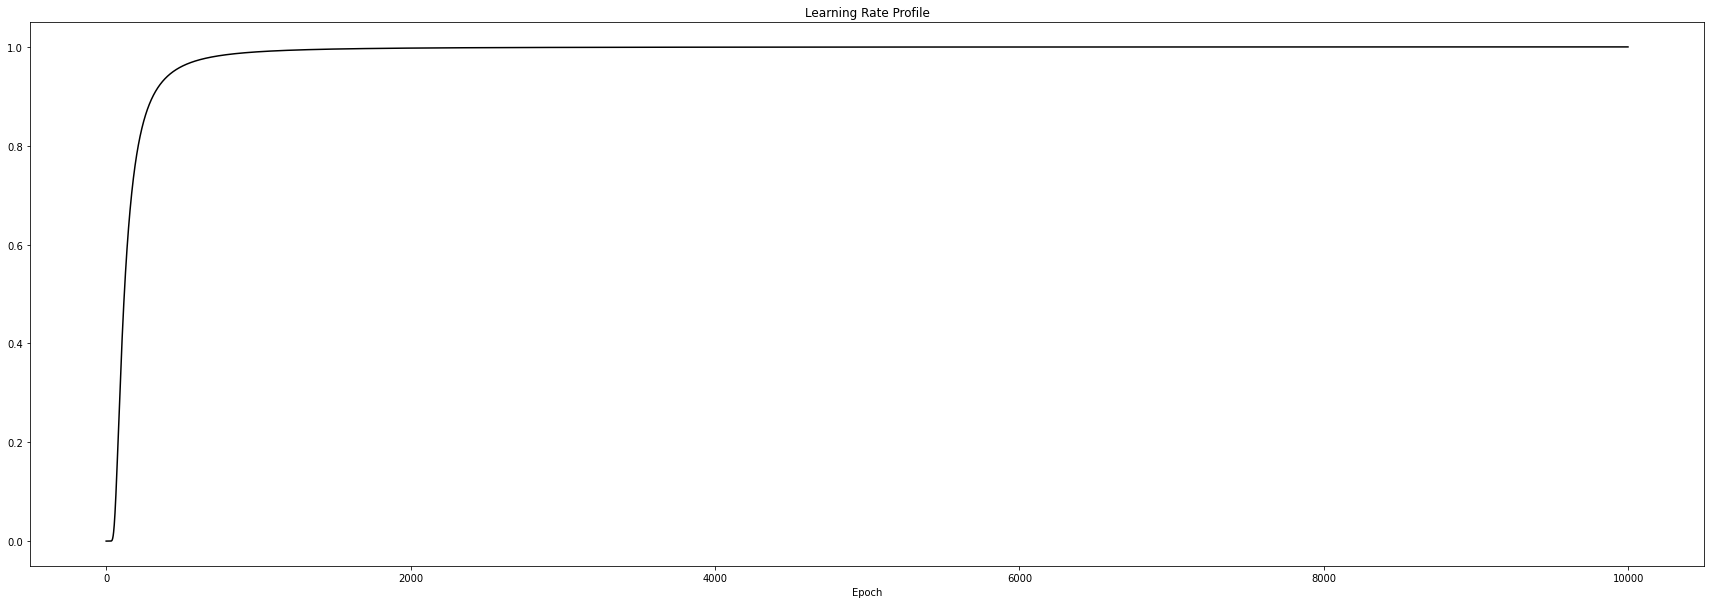

In [25]:
num_epoch = 10000
alpha =  100 / num_epoch
lr_sigmoid = lambda xx: np.exp(- 1 / ((xx + 1) * alpha) ** 2)

xx = np.arange(num_epoch)
yy = lr_sigmoid(xx)

plt.figure(figsize=(30, 10))
plt.plot(xx, yy, c='k')
plt.title('Learning Rate Profile')
plt.xlabel('Epoch')
#plt.xlim([0, 300])


In [31]:
from recognition_parametrised_model import RPM
import torch.nn.functional as F

dim_latent = 2


prior_params = {
    'fit_prior_mean_param':False,
    'fit_kernel_scale':False,
    'fit_kernel_scale_prior':False,
    'fit_kernel_lengthscale':False,
    'fit_kernel_lengthscale_prior':False,
    'optimizer': lambda params: torch.optim.RMSprop(params=params, lr=1e-3),
    'scheduler': lambda optim: torch.optim.lr_scheduler.LambdaLR(optim, lr_sigmoid),
}


factors_params = {
    'channels': [[1, 10, 10], []],
    'kernel_conv': [[3, 3], []],
    'kernel_pool': [[1, 1], []],
    'dim_hidden': [[10, 10], []],
    'non_linearity': [F.relu, torch.nn.Identity],
    'covariance': ['fixed', 'fixed'],
    'optimizer': lambda params: torch.optim.RMSprop(params=params, lr=1e-3),
    'scheduler': lambda optim: torch.optim.lr_scheduler.LambdaLR(optim, lr_sigmoid),
}

auxiliary_params = {
    'channels': [[1, 10, 10], []],
    'kernel_conv': [[3, 3], []],
    'kernel_pool': [[1, 1], []],
    'dim_hidden': [[10, 10], []],
    'non_linearity': [F.relu, torch.nn.Identity],
    'covariance': ['fixed', 'fixed'],
    'optimizer': lambda params: torch.optim.RMSprop(params=params, lr=1e-3),
    'scheduler': lambda optim: torch.optim.lr_scheduler.LambdaLR(optim, lr_sigmoid),
}

variational_params = {
    'inference_mode': 'amortized',  # 'amortized', 'parametrized'
    'channels': [[1, 10, 10], []],
    'kernel_conv': [[3, 3], []],
    'kernel_pool': [[1, 1], []],
    'dim_hidden': [[10, 10], []],
    'dim_hidden_merged': [],
    'non_linearity': [F.relu, torch.nn.Identity],
    'non_linearity_merged': F.relu,
    'covariance': 'fixed_diag',
    'optimizer': lambda params: torch.optim.RMSprop(params=params, lr=1e-3),
    'scheduler': lambda optim: torch.optim.lr_scheduler.LambdaLR(optim, lr_sigmoid),
}

fit_params = {
    'num_epoch': num_epoch,
    'batch_size': 500,
    'dim_latent': 3,
    'prior_params': prior_params,
    'factors_params': factors_params,
    'auxiliary_params': auxiliary_params,
    'variational_params': variational_params,
    'pct':0.01,
}

len_observations = 1
observation_locations = torch.linspace(0, 1, len_observations).unsqueeze(-1).to(device)

rpm = RPM(
    observations=observations_train,
    observation_locations=observation_locations,
    fit_params=fit_params,
)

rpm.fit(observations_train)


RPM on GPU Observations on cuda:0
Epoch 100/10000 Loss: 1.927519e+01
Epoch 200/10000 Loss: 1.535293e+01
Epoch 300/10000 Loss: 1.316599e+01
Epoch 400/10000 Loss: 1.217110e+01
Epoch 500/10000 Loss: 1.181453e+01
Epoch 600/10000 Loss: 1.156786e+01
Epoch 700/10000 Loss: 1.128413e+01
Epoch 800/10000 Loss: 1.104337e+01
Epoch 900/10000 Loss: 1.083699e+01
Epoch 1000/10000 Loss: 1.069607e+01
Epoch 1100/10000 Loss: 1.056550e+01
Epoch 1200/10000 Loss: 1.045021e+01
Epoch 1300/10000 Loss: 1.052737e+01
Epoch 1400/10000 Loss: 1.036677e+01
Epoch 1500/10000 Loss: 1.024997e+01
Epoch 1600/10000 Loss: 1.019757e+01
Epoch 1700/10000 Loss: 1.029608e+01
Epoch 1800/10000 Loss: 1.011154e+01
Epoch 1900/10000 Loss: 1.013760e+01
Epoch 2000/10000 Loss: 9.994645e+00
Epoch 2100/10000 Loss: 1.006382e+01
Epoch 2200/10000 Loss: 1.007932e+01
Epoch 2300/10000 Loss: 9.996986e+00
Epoch 2400/10000 Loss: 9.903725e+00
Epoch 2500/10000 Loss: 9.894297e+00
Epoch 2600/10000 Loss: 9.844342e+00
Epoch 2700/10000 Loss: 9.927789e+00
Epo

KeyboardInterrupt: 

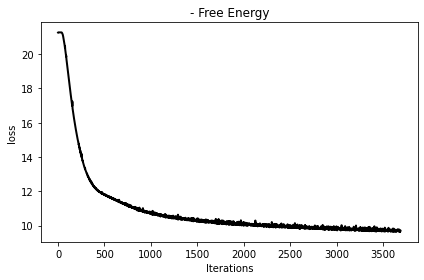

In [32]:
from utils_process import plot_loss
plot_loss(rpm, offset=0)


In [33]:

observations = observations_train
with torch.no_grad():
    rpm.num_observation_batch = observations[0].shape[0]    
    rpm._update_all(observations)    

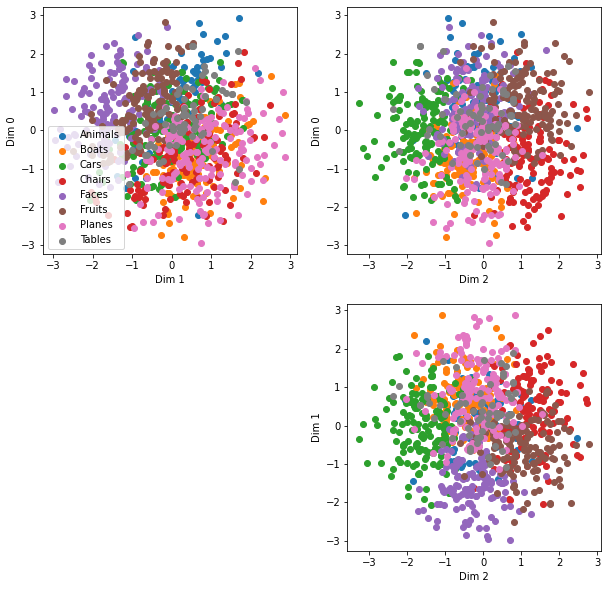

In [34]:
from matplotlib import pyplot as plt


latent_true = true_latent_train
posterior_mean = rpm.dist_marginals.suff_stat_mean[0].squeeze(1).detach().to('cpu')

dim_latent = rpm.dim_latent
plot_width = dim_latent - 1
plot_heigh = dim_latent - 1
plt.figure(figsize=(5 * plot_width, 5 * plot_heigh))
for ii in np.arange(dim_latent):
    for jj in np.arange(ii + 1, dim_latent):
        plt.subplot(plot_heigh, plot_width, jj + ii * (dim_latent - 1))
        for class_id in range(len(np.unique(latent_true))):
            mask = latent_true == class_id
            plt.scatter(posterior_mean[mask, jj], posterior_mean[mask, ii], label=label_basic[class_id])
            plt.xlabel('Dim ' + str(jj))
            plt.ylabel('Dim ' + str(ii))

        if ii == 0 and jj == 1:
            plt.legend()


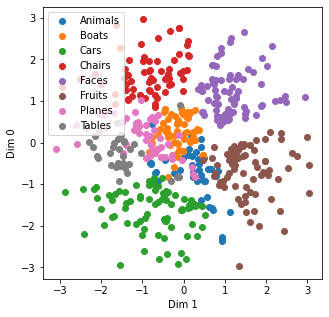

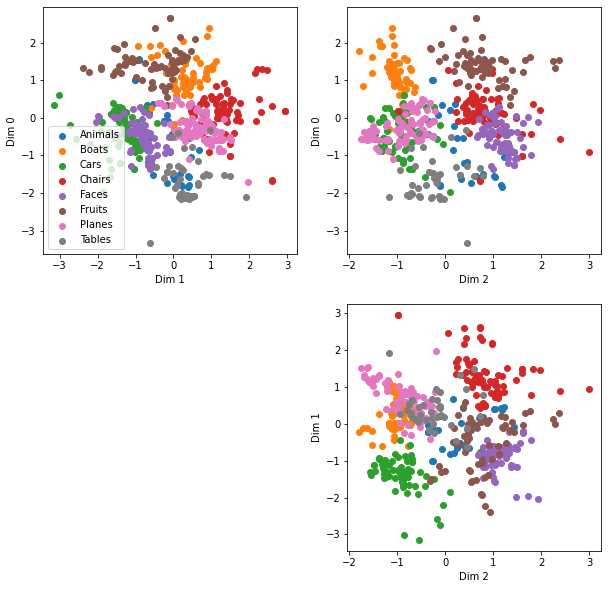

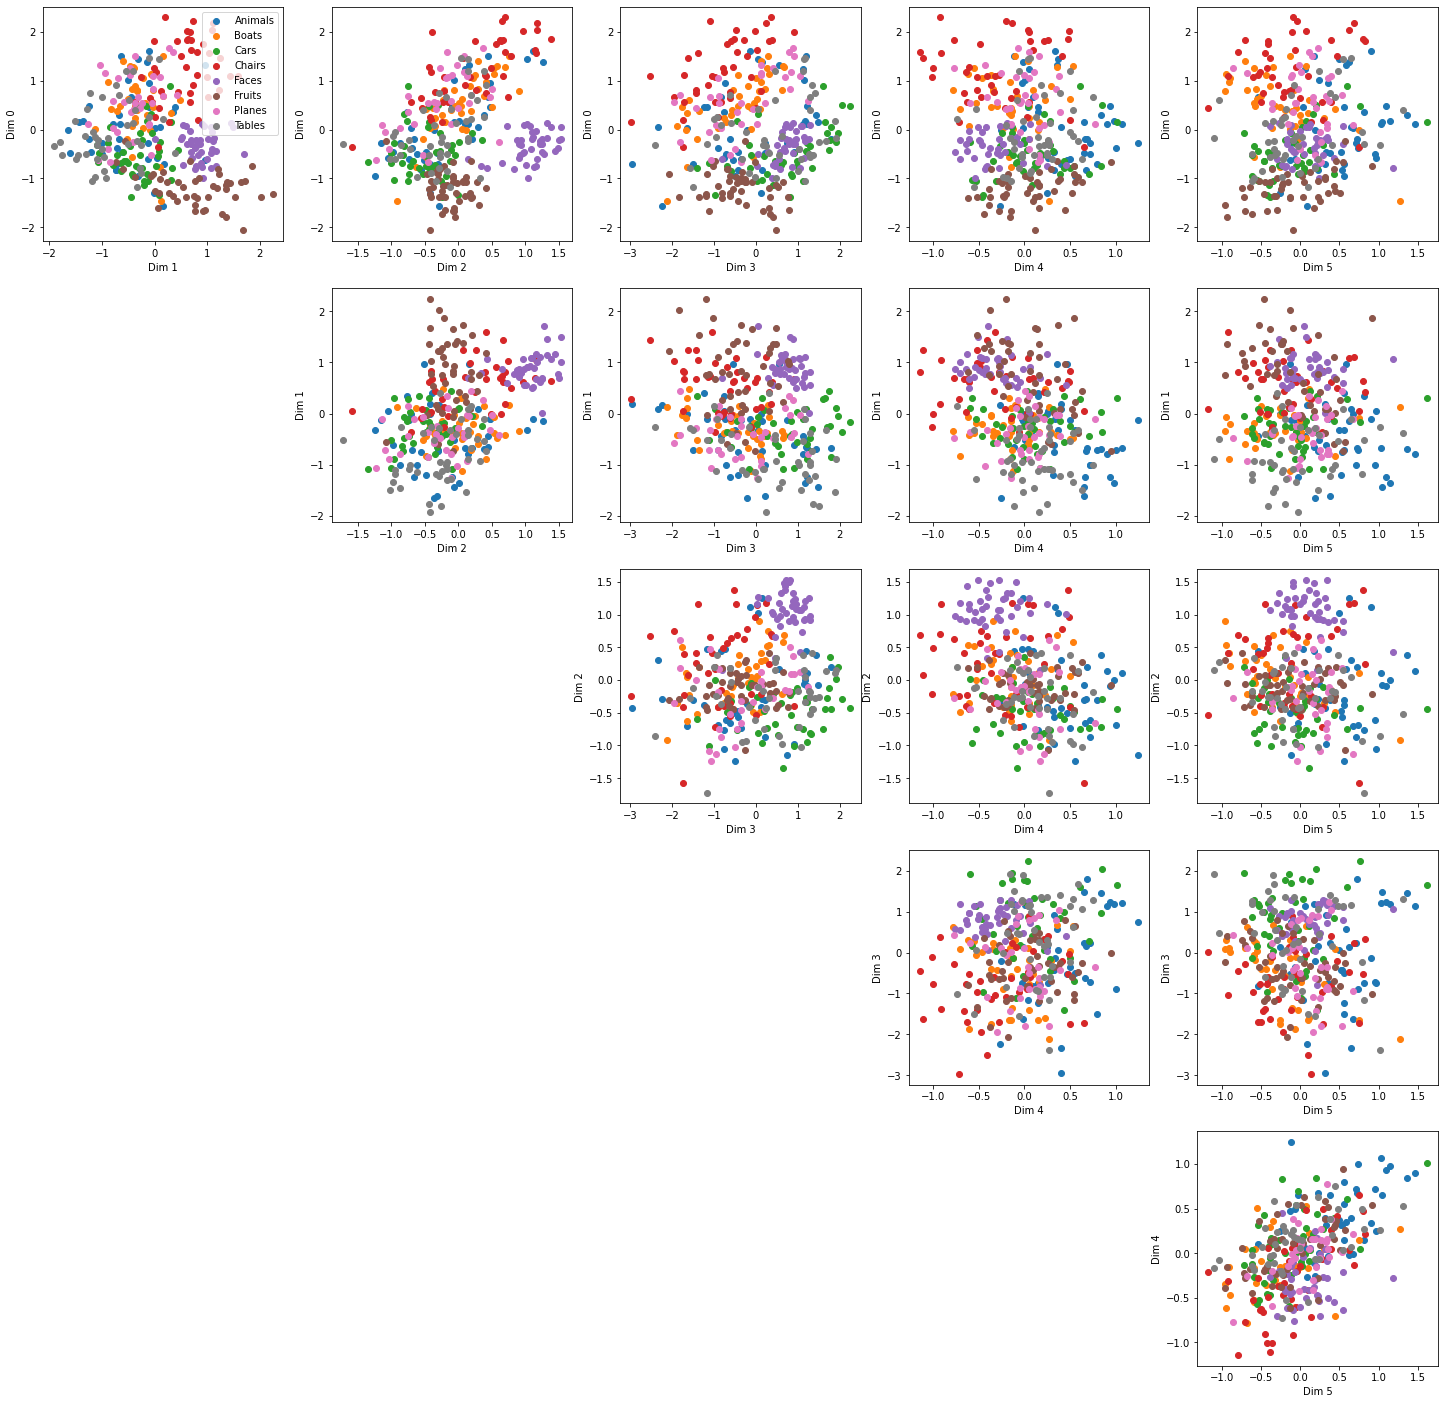

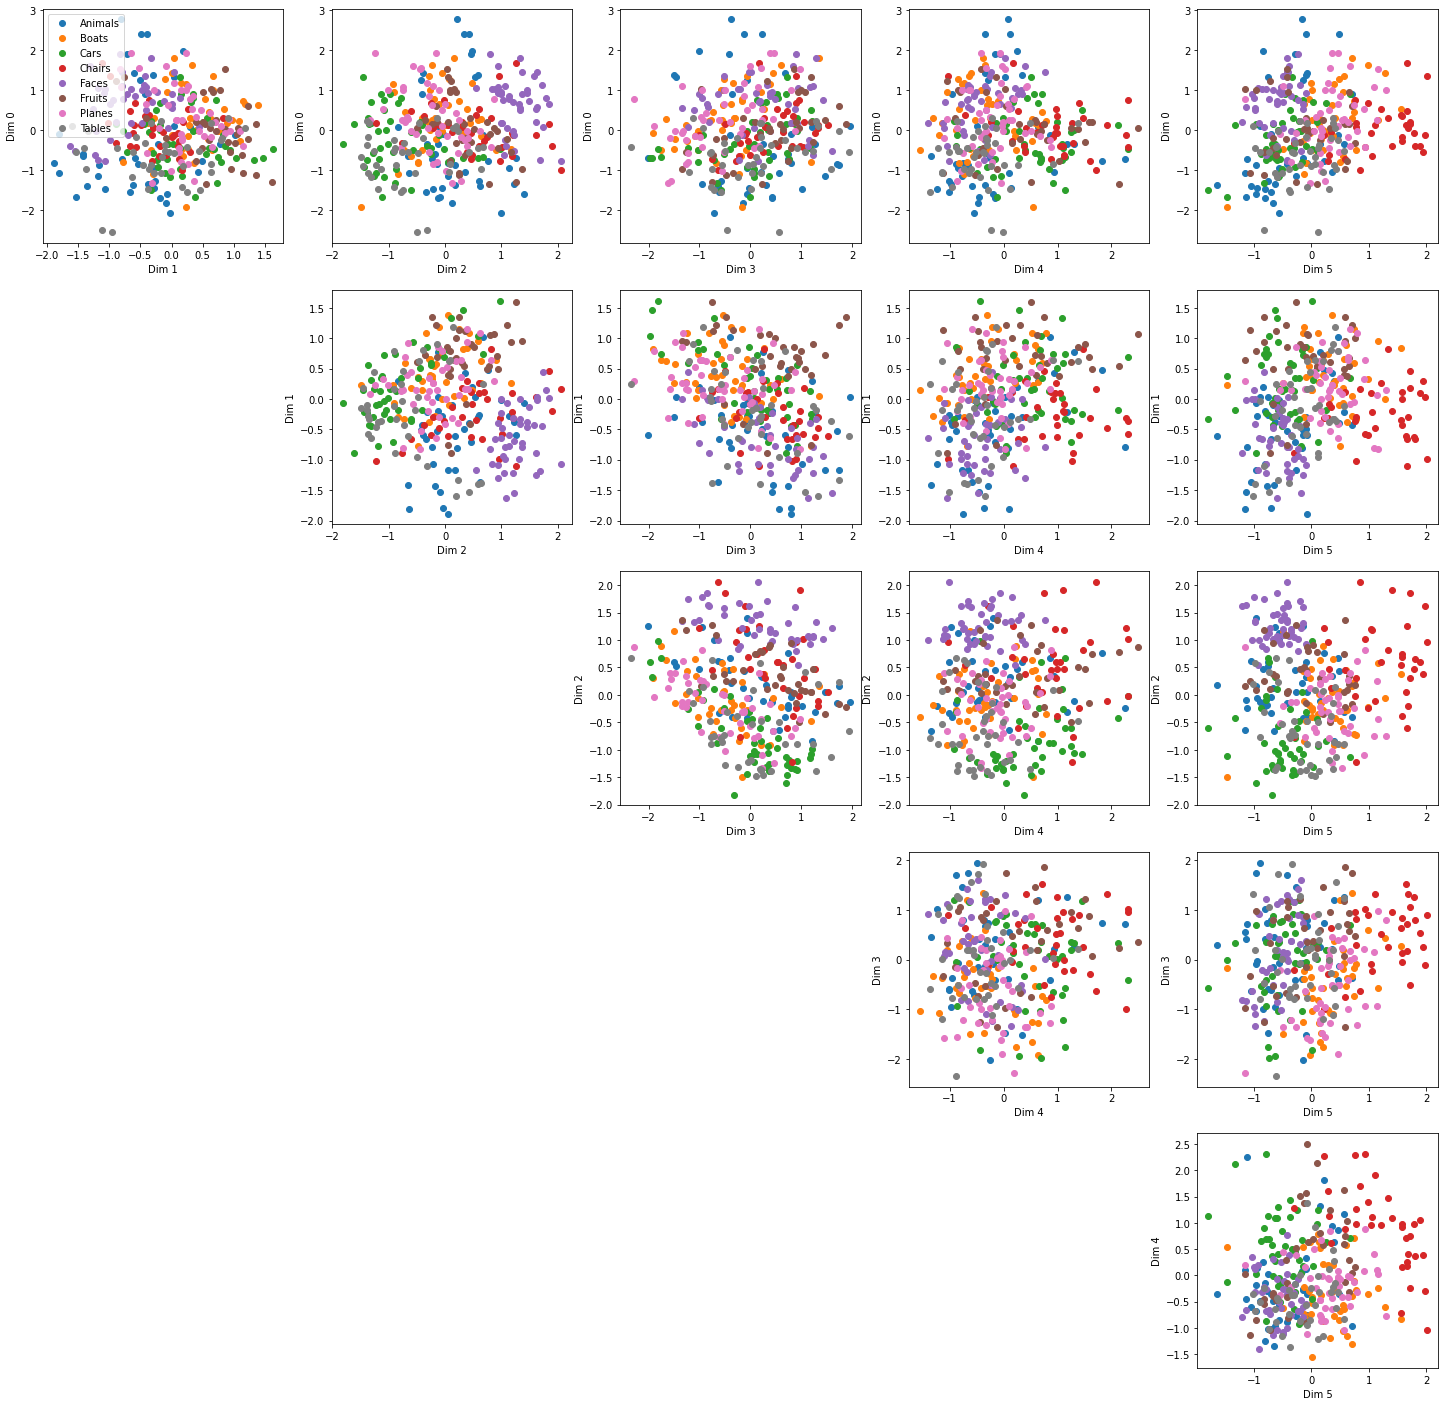

In [77]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def confidence_ellipse(cov, ax, n_std=3.0, facecolor='none', **kwargs):


    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(0, 0)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

(-1.0, 1.0)

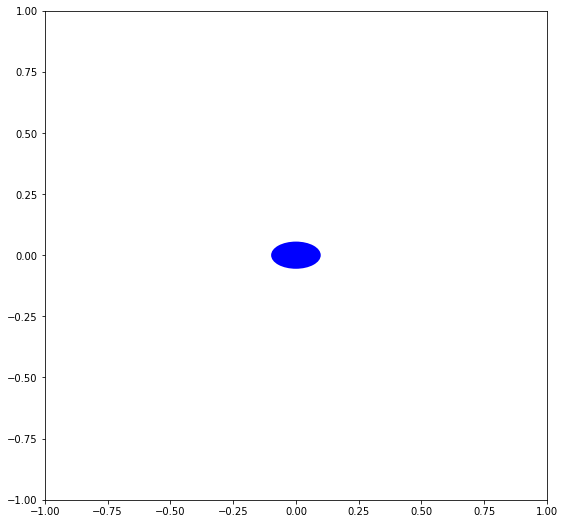

In [103]:
qdist = rpm.dist_marginals.mean_covariance()
qmean, qcov = [q.detach().cpu().numpy() for q in qdist]

nn = 0
qcov = qcov[nn, 0] 

dim1 = 0
dim2 = 1

qcov = qcov[[dim1,dim2]][:, [dim1,dim2]]

#fig, axs = plt.subplots(1, 1, figsize=(9, 3))

fig, axs = plt.subplots(1, 1, figsize=(9, 9))
confidence_ellipse(qcov, axs, n_std=0.1, facecolor='b')
plt.xlim([-1, 1])
plt.ylim([-1, 1])


In [ ]:
np.random.seed(0)

PARAMETERS = {
    'Positive correlation': [[0.85, 0.35],
                             [0.15, -0.65]],
    'Negative correlation': [[0.9, -0.4],
                             [0.1, -0.6]],
    'Weak correlation': [[1, 0],
                         [0, 1]],
}

mu = 2, 4
scale = 3, 5

fig, axs = plt.subplots(1, 3, figsize=(9, 3))
for ax, (title, dependency) in zip(axs, PARAMETERS.items()):
    x, y = get_correlated_dataset(800, dependency, mu, scale)
    ax.scatter(x, y, s=0.5)

    ax.axvline(c='grey', lw=1)
    ax.axhline(c='grey', lw=1)

    confidence_ellipse(x, y, ax, edgecolor='red')

    ax.scatter(mu[0], mu[1], c='red', s=3)
    ax.set_title(title)

plt.show()